# The Split-Bregman Algorithm: Sparsity Enforcing Inversions

@Author: Francesco Picetti - francesco.picetti@polimi.it

In this notebook we will show the Split-Bregman algorithm,
as described by [Goldstein and Osher, 2009](https://doi.org/10.1137/080725891).

In its generalized unconstrained formulation (the same we handle in this library), this algorithm
takes what we call `RegularizedLeastSquares` (see `occamypy.problem` module):

\begin{equation}
    \arg \min_\mathbf{x} \Vert  \mathbf{A} \mathbf{x} - \mathbf{d}\Vert_2^2 + \sum_i \varepsilon_{L2,i}\Vert \mathbf{R}_{L2,i} \mathbf{x} - \mathbf{p}_i\Vert_2^2 + \sum_i \varepsilon_{L1,i}\Vert \mathbf{R}_{L1,i} \mathbf{x}\Vert_1,
\end{equation}

being $\mathbf{x}$ our model, $\mathbf{d}$ the observed data, $\mathbf{A}$ a linear modeling operator,
$\mathbf{R}_{L2,i}$ the $i$-th linear regularizer to which we associate a prior $\mathbf{p}_i$ along with its weight $\varepsilon_{L2,i}$,
$\mathbf{R}_{L1,i}$ the $i$-th sparsity promoting regularizer and its weight $\varepsilon_{L1,i}$.

#### Import modules

In [1]:
# Importing necessary modules
import numpy as np
import occamypy

# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':True
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


##  Example 1:  1D Ricker Deconvolution

In this example we want to invert a 1D seismic trace for the Earth's reflectivity.
We suppose the wavelet to be known, yielding  to a deterministic deconvolution problem.

In [2]:
# load wavelet
wav = occamypy.VectorIC(np.load("./data/ricker20.npy"))
nt = 51.
ot = 0.
dt = 0.002

# load reflectivity
x = occamypy.VectorIC(np.load("./data/reflectivity1D.npy"))
time_axis = np.arange(x.size)*dt

# instantating operator
W = occamypy.ConvND(x, wav)

# Generating true recorded trace
d = W * x

# Compute spectra
nfft = 4096
x_spectra = np.fft.fft(x.getNdArray(), nfft)
d_spectra = np.fft.fft(d.getNdArray(), nfft)
w_spectra = np.fft.fft(wav.getNdArray(), nfft)
freq = np.fft.fftfreq(nfft, dt)

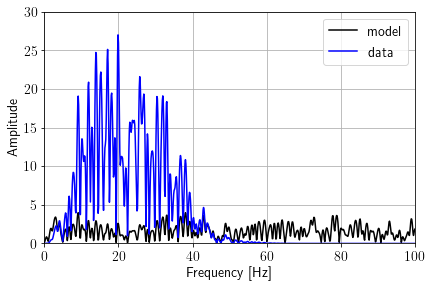

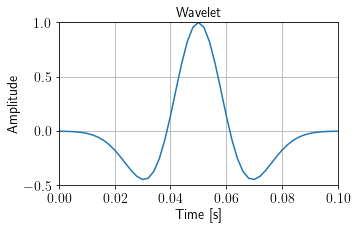

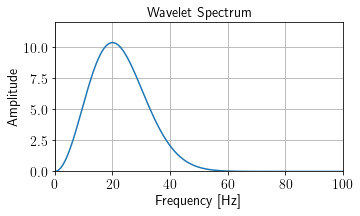

In [3]:
, ax = plt.subplots(figsize=(12, 3))
plt.plot(freq[:nfft//4], np.abs(x_spectra)[:nfft//4], 'k',  label='model')
plt.plot(freq[:nfft//4], np.abs(d_spectra)[:nfft//4], 'b',  label='data')
plt.legend(loc='upper right')
plt.xlabel("Frequency [Hz]"), plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0,100), plt.ylim(0,30)
plt.tight_layout(pad=0.5)
# plt.savefig('ricker_model_freq.pdf')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(np.arange(wav.size)*dt, wav.getNdArray())
plt.title('Wavelet')
plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0,0.1), plt.ylim(-0.5,1)
plt.show()

plt.figure(figsize=(5,3))
plt.plot(freq[:nfft//4], np.abs(w_spectra)[:nfft//4])
plt.title('Wavelet Spectrum')
plt.xlabel("Frequency [Hz]"), plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0,100), plt.ylim(0,12)

plt.tight_layout(pad=0.5)
# plt.savefig('ricker_wavelet_freq.pdf')

plt.show()

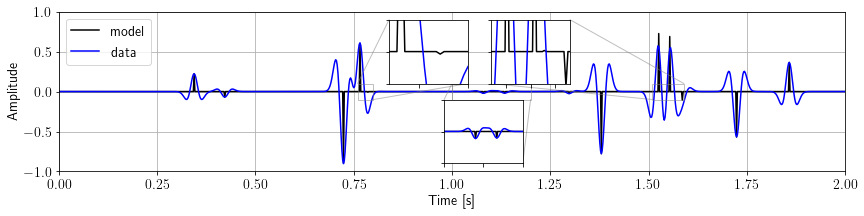

In [4]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(time_axis, x.getNdArray(), 'k',  label='model')
ax.plot(time_axis, d.getNdArray(), 'b',  label='data')
ax.legend(loc='upper left')
ax.set_ylim(-1., 1.), ax.set_xlim(0,2)
ax.set_xlabel("Time [s]"), ax.set_ylabel("Amplitude")
ax.grid(True)

axins1 = ax.inset_axes([0.42, 0.55, 0.1, 0.4])
axins1.plot(time_axis, x.getNdArray(), 'k')
axins1.plot(time_axis, d.getNdArray(), 'b')
axins1.set_xlim(0.76, 0.8)
axins1.set_ylim(-.1, .1)
axins1.set_xticklabels('')
axins1.set_yticklabels('') 
ax.indicate_inset_zoom(axins1)

axins2 = ax.inset_axes([0.55, 0.55, 0.1, 0.4])
axins2.plot(time_axis, x.getNdArray(), 'k')
axins2.plot(time_axis, d.getNdArray(), 'b')
axins2.set_xlim(1.51, 1.59)
axins2.set_ylim(-.1, .1)
axins2.set_xticklabels('')
axins2.set_yticklabels('') 
ax.indicate_inset_zoom(axins2)

axins3 = ax.inset_axes([0.49, 0.05, 0.1, 0.4])
axins3.plot(time_axis, x.getNdArray(), 'k')
axins3.plot(time_axis, d.getNdArray(), 'b')
axins3.set_xlim(1.0, 1.2)
axins3.set_ylim(-.1, .1)
axins3.set_xticklabels('')
axins3.set_yticklabels('') 
ax.indicate_inset_zoom(axins3)

plt.tight_layout(pad=0.5)
#plt.savefig('ricker_model.pdf')
plt.show()

#### Solve with Conjugate Gradient

Conjugate gradient is a fast and powerful adjoint-state algorithm for solving problems in the form:

\begin{equation}
    \hat{\mathbf{x}} = \arg \min_\mathbf{x} \Vert \mathbf{W}\mathbf{x} - \mathbf{d}\Vert_2^2
\end{equation}

In [5]:
# instantiate a linear L2 problem
problemCG = occamypy.LeastSquares(x.clone().zero(), d, W)

# define the solver with 10'000 iterations
CG = occamypy.CG(occamypy.BasicStopper(10000))
CG.setDefaults(save_obj=True)

# solve the problem
CG.run(problemCG, verbose=False)

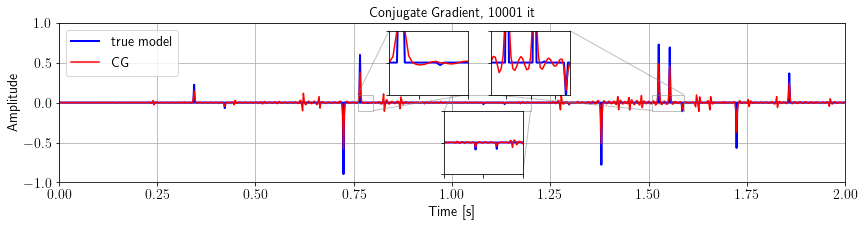

In [6]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(time_axis, x.getNdArray(), 'b', lw=2, label='true model')
ax.plot(time_axis, problemCG.model.getNdArray(), 'r',  label='CG')
ax.legend(loc='upper left')
ax.set_ylim(-1., 1.), ax.set_xlim(0,2)
ax.set_xlabel("Time [s]"), ax.set_ylabel("Amplitude")
ax.grid(True)

axins1 = ax.inset_axes([0.42, 0.55, 0.1, 0.4])
axins1.plot(time_axis, x.getNdArray(), 'b', lw=2)
axins1.plot(time_axis, problemCG.model.getNdArray(), 'r')
axins1.set_xlim(0.76, 0.8)
axins1.set_ylim(-.1, .1)
axins1.set_xticklabels('')
axins1.set_yticklabels('') 
ax.indicate_inset_zoom(axins1)

axins2 = ax.inset_axes([0.55, 0.55, 0.1, 0.4])
axins2.plot(time_axis, x.getNdArray(), 'b', lw=2)
axins2.plot(time_axis, problemCG.model.getNdArray(), 'r')
axins2.set_xlim(1.51, 1.59)
axins2.set_ylim(-.1, .1)
axins2.set_xticklabels('')
axins2.set_yticklabels('') 
ax.indicate_inset_zoom(axins2)

axins3 = ax.inset_axes([0.49, 0.05, 0.1, 0.4])
axins3.plot(time_axis, x.getNdArray(), 'b', lw=2)
axins3.plot(time_axis, problemCG.model.getNdArray(), 'r')
axins3.set_xlim(1.0, 1.2)
axins3.set_ylim(-.1, .1)
axins3.set_xticklabels('')
axins3.set_yticklabels('') 
ax.indicate_inset_zoom(axins3)

plt.tight_layout(pad=0.5)
plt.title('Conjugate Gradient, %d it' % len(CG.obj))
#plt.savefig("ricker_cg.pdf")
plt.show()

#### Impose sparsity in the solution: FISTA

Iterative Shrinkage-Thresholding Algorithms solve the so-called LASSO problem:
\begin{equation}
    \hat{\mathbf{x}} = \arg \min_\mathbf{x} \Vert \mathbf{W}\mathbf{x} - \mathbf{d}\Vert_2^2 + \lambda \Vert \mathbf{x}\Vert_1
\end{equation}

If we provide the operator's maximum eigenvalue $\eta$ we can build a fast version
of this algorithm by imposing the step $\alpha < 1/\eta^2$ as proposed in [Beck and Teboulle, 2009](https://doi.org/10.1137/080716542).

In [7]:
# compute maximum eigenvalue
maxeig = W.powerMethod()
print('FISTA α=%.6e' % (1/(maxeig**2)))

# define the LASSO problem
problemFISTA = occamypy.Lasso(x.clone().zero(), d, W, lambda_value=1, op_norm=maxeig**2)

# instantiate the fast solver with 1000 iterations
FISTA = occamypy.ISTA(occamypy.BasicStopper(10000), fast=True)
FISTA.setDefaults(save_obj=True)

# solve the problem
FISTA.run(problemFISTA, verbose=False)

FISTA α=9.305017e-03


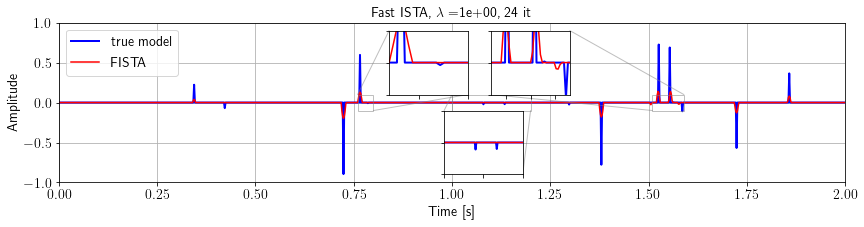

In [8]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(time_axis, x.getNdArray(), 'b', lw=2, label='true model')
ax.plot(time_axis, problemFISTA.model.getNdArray(), 'r',  label='FISTA')
ax.legend(loc='upper left')
ax.set_ylim(-1., 1.), ax.set_xlim(0,2)
ax.set_xlabel("Time [s]"), ax.set_ylabel("Amplitude")
ax.grid(True)

axins1 = ax.inset_axes([0.42, 0.55, 0.1, 0.4])
axins1.plot(time_axis, x.getNdArray(), 'b', lw=2)
axins1.plot(time_axis, problemFISTA.model.getNdArray(), 'r')
axins1.set_xlim(0.76, 0.8)
axins1.set_ylim(-.1, .1)
axins1.set_xticklabels('')
axins1.set_yticklabels('') 
ax.indicate_inset_zoom(axins1)

axins2 = ax.inset_axes([0.55, 0.55, 0.1, 0.4])
axins2.plot(time_axis, x.getNdArray(), 'b', lw=2)
axins2.plot(time_axis, problemFISTA.model.getNdArray(), 'r')
axins2.set_xlim(1.51, 1.59)
axins2.set_ylim(-.1, .1)
axins2.set_xticklabels('')
axins2.set_yticklabels('') 
ax.indicate_inset_zoom(axins2)

axins3 = ax.inset_axes([0.49, 0.05, 0.1, 0.4])
axins3.plot(time_axis, x.getNdArray(), 'b', lw=2)
axins3.plot(time_axis, problemFISTA.model.getNdArray(), 'r')
axins3.set_xlim(1.0, 1.2)
axins3.set_ylim(-.1, .1)
axins3.set_xticklabels('')
axins3.set_yticklabels('') 
ax.indicate_inset_zoom(axins3)

plt.tight_layout(pad=0.5)
plt.title(r'Fast ISTA, $\lambda=$%.e, %d it' % (problemFISTA.lambda_value, len(FISTA.obj)))
#plt.savefig("ricker_fista10.pdf")
plt.show()

Note that FISTA is able to recover the model's kinematics but not the true amplitude.
Indeed, this algorithm is very sensitive to $\lambda$ parameter.
Let's try another solver.

#### Split-Bregman for LASSO problem

In [9]:
# define the Linear Regularized Problem
problemSB = occamypy.RegularizedLeastSquares(x.clone().zero(), d, W,
                                             regsL1=occamypy.IdentityOp(x), epsL1=.1)

# instantiate the Split-Bregman solver
SB = occamypy.SplitBregman(occamypy.BasicStopper(1000), niter_inner=3, niter_solver=5,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True)
# solve the problem
SB.run(problemSB, verbose=False, inner_verbose=False)

In [10]:
its = "%d-%d-%d" % (len(SB.obj), SB.niter_inner, SB.niter_solver)

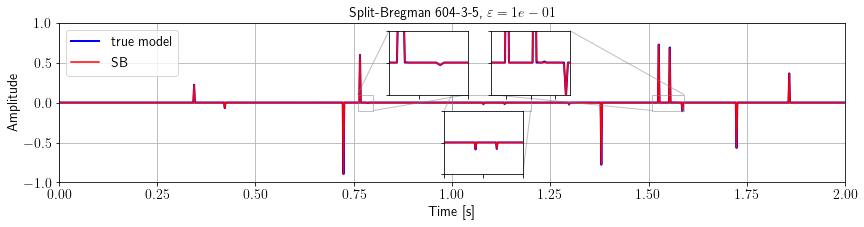

In [11]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(time_axis, x.getNdArray(), 'b', lw=2, label='true model')
ax.plot(time_axis, problemSB.model.getNdArray(), 'r',  label='SB')
ax.legend(loc='upper left')
ax.set_ylim(-1., 1.), ax.set_xlim(0,2)
ax.set_xlabel("Time [s]"), ax.set_ylabel("Amplitude")
ax.grid(True)

axins1 = ax.inset_axes([0.42, 0.55, 0.1, 0.4])
axins1.plot(time_axis, x.getNdArray(), 'b', lw=2)
axins1.plot(time_axis, problemSB.model.getNdArray(), 'r')
axins1.set_xlim(0.76, 0.8)
axins1.set_ylim(-.1, .1)
axins1.set_xticklabels('')
axins1.set_yticklabels('') 
ax.indicate_inset_zoom(axins1)

axins2 = ax.inset_axes([0.55, 0.55, 0.1, 0.4])
axins2.plot(time_axis, x.getNdArray(), 'b', lw=2)
axins2.plot(time_axis, problemSB.model.getNdArray(), 'r')
axins2.set_xlim(1.51, 1.59)
axins2.set_ylim(-.1, .1)
axins2.set_xticklabels('')
axins2.set_yticklabels('') 
ax.indicate_inset_zoom(axins2)

axins3 = ax.inset_axes([0.49, 0.05, 0.1, 0.4])
axins3.plot(time_axis, x.getNdArray(), 'b', lw=2)
axins3.plot(time_axis, problemSB.model.getNdArray(), 'r')
axins3.set_xlim(1.0, 1.2)
axins3.set_ylim(-.1, .1)
axins3.set_xticklabels('')
axins3.set_yticklabels('') 
ax.indicate_inset_zoom(axins3)

plt.tight_layout(pad=0.5)
plt.title(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problemSB.epsL1[0]))
#plt.savefig("ricker_sb_%s.pdf" %its)
plt.show()

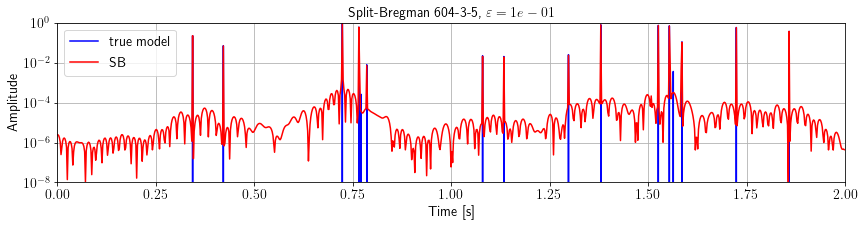

In [12]:
fig, ax = plt.subplots(figsize=(12,3))
plt.semilogy(time_axis, np.abs(x.getNdArray()), 'b', label="true model")
plt.semilogy(time_axis, np.abs(problemSB.model.getNdArray()), 'r', label="SB")
plt.xlim(0,2), plt.ylim(1e-8, 1)
plt.legend(loc='upper left')
plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout(pad=0.5)
plt.title(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problemSB.epsL1[0]))
#plt.savefig("ricker_sb_%s_log.pdf" % its)
plt.show()

The results is much better than FISTA output: the dynamics is almost-perfectly recovered.


##  Example 2:  1D Velocity Deconvolution

Now we create a synthetic velocity profile and suppose to have recorded a smooth version of it.
The deconvolution problem aims at recovering the sharp model, and this is done by using a Total Variation regularizer.

In [13]:
# create the true model
nx = 201
x = occamypy.VectorIC((nx,)).zero()
x.getNdArray()[20:30] = 10.
x.getNdArray()[50:75] = -5.
x.getNdArray()[100:150] = 2.5
x.getNdArray()[175:180] = 7.5

# instantiate the blurring operator
G = occamypy.GaussianFilter(x, 2.0)

# simulate data
d = G * x

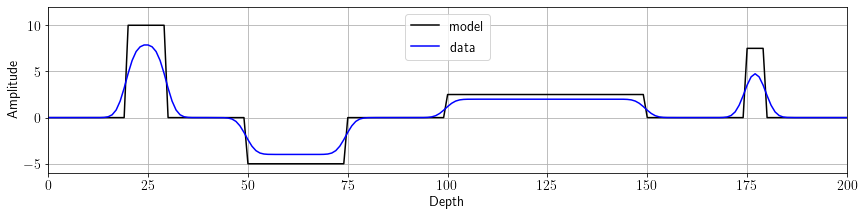

In [14]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), 'k',  label='model')
plt.plot(d.getNdArray(), 'b',  label='data')
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim(-6, 12)
plt.legend(loc="upper center")
plt.grid(True)
plt.xlabel("Depth"), plt.ylabel("Amplitude")
plt.tight_layout(pad=.5)
#plt.savefig("blocky_model.pdf")
plt.show()

As we can see, the model presents some flat regions. Let's have a look to its first derivative:

In [15]:
D = occamypy.FirstDerivative(x, stencil='forward')
Dx = D * x

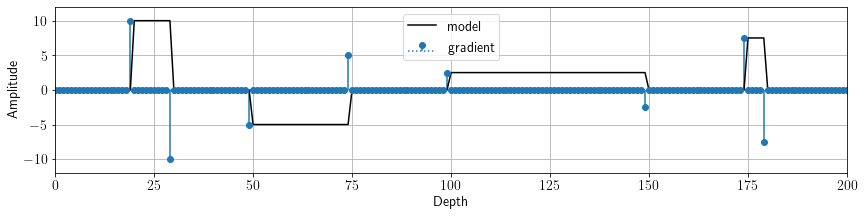

In [16]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), 'k',  label='model')
plt.stem(Dx.getNdArray(), label='gradient', basefmt=':', use_line_collection=True)
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim(-12, 12)
plt.legend(loc="upper center")
plt.grid(True)
plt.xlabel("Depth"), plt.ylabel("Amplitude")
plt.tight_layout(pad=.5)
plt.show()

The model derivative is sparse! We can set up a SplitBregman solver:

In [17]:
problem = occamypy.RegularizedLeastSquares(x.clone().zero(), d, G, regsL1=D, epsL1=.1)

SB = occamypy.SplitBregman(occamypy.BasicStopper(200), niter_inner=3, niter_solver=10,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True, save_model=True)

SB.run(problem, verbose=False, inner_verbose=False)

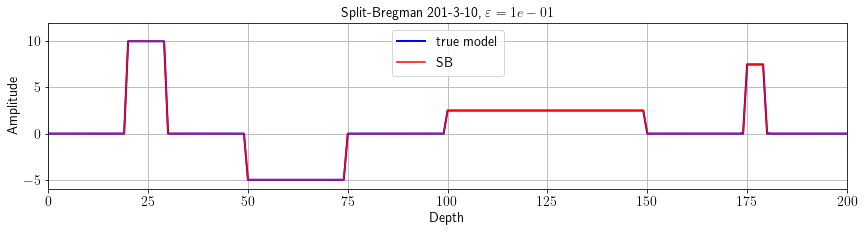

In [18]:
its = "%d-%d-%d" % (len(SB.obj), SB.niter_inner, SB.niter_solver)

fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), 'b', lw=2, label="true model")
plt.plot(problem.model.getNdArray(), 'r', label="SB")
plt.ylim(-6, 12), plt.xlim(0, 200)
plt.legend(loc="upper center")
plt.grid(True)
plt.xlabel("Depth"), plt.ylabel("Amplitude")
plt.tight_layout(pad=.5)

plt.title(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problem.epsL1[0]))
#plt.savefig("blocky_sb_%s.pdf" % its)
plt.show()

Let's check the convergence:

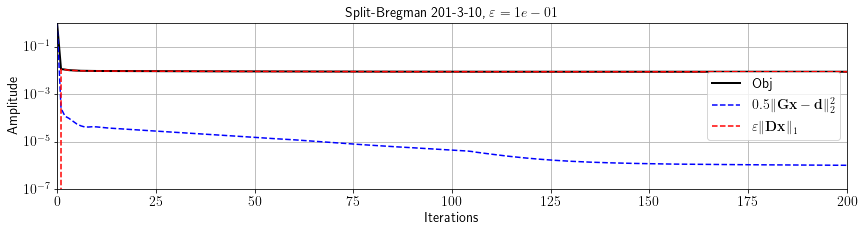

In [19]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.semilogy(SB.obj / SB.obj[0], 'k', lw=2, label='Obj')
plt.semilogy(SB.obj_terms[:, 0] / SB.obj[0], 'b--', label=r"$0.5 \Vert \mathbf{Gx-d} \Vert_2^2$")
plt.semilogy(SB.obj_terms[:, 1] / SB.obj[0], 'r--', label=r"$\varepsilon \Vert \mathbf{Dx}\Vert_1$")
plt.ylim(1e-7, 1), plt.xlim(0, SB.stopper.niter)
plt.xlabel("Iterations"), plt.ylabel("Amplitude")
plt.legend(loc="right"), plt.grid(True)
plt.tight_layout(pad=.5)

plt.title(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problem.epsL1[0]))
#plt.savefig("blocky_sb_convergence.pdf")
plt.show()

We can see that the L1 term reaches its final value after few iterations.
Let's see the inverted model after 2 iterations:

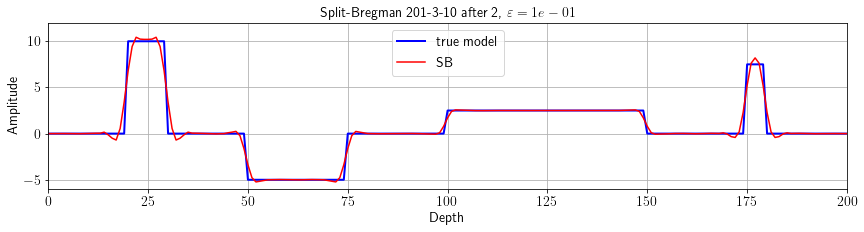

In [20]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), 'b', lw=2, label="true model")
plt.plot(SB.model[2].getNdArray(), 'r', label="SB")
plt.ylim(-6, 12), plt.xlim(0, 200)
plt.legend(loc="upper center")
plt.grid(True)
plt.xlabel("Depth"), plt.ylabel("Amplitude")
plt.tight_layout(pad=.5)

plt.title(r'Split-Bregman %s after 2, $\varepsilon=%.e$' % (its, problem.epsL1[0]))
#plt.savefig("blocky_sb_%s_after2.pdf" % its)
plt.show()

Just for comparison, let's solve the problem with CG and FISTA.

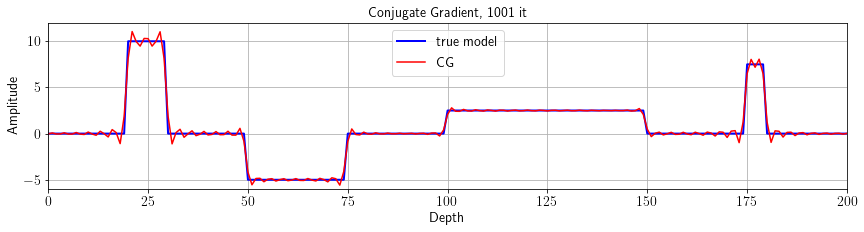

In [21]:
problemCG = occamypy.LeastSquares(x.clone().zero(), d, G)
CG = occamypy.CG(occamypy.BasicStopper(1000))
CG.setDefaults(save_obj=True)
CG.run(problemCG, verbose=False)

fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), 'b', lw=2, label="true model")
plt.plot(problemCG.model.getNdArray(), 'r', label="CG")
plt.ylim(-6, 12), plt.xlim(0, 200)
plt.legend(loc="upper center")
plt.grid(True)
plt.xlabel("Depth"), plt.ylabel("Amplitude")
plt.tight_layout(pad=.5)

plt.title('Conjugate Gradient, %d it' % len(CG.obj))
#plt.savefig("blocky_cg.pdf")
plt.show()

FISTA α=1.570829e+00


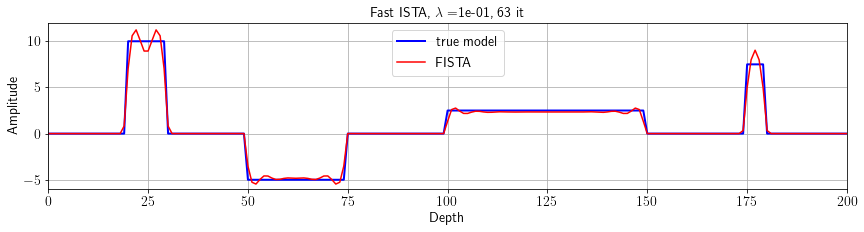

In [22]:
# compute maximum eigenvalue
maxeig = G.powerMethod()
print('FISTA α=%.6e' % (1/(maxeig**2)))
problemFISTA = occamypy.Lasso(x.clone().zero(), d, G, lambda_value=.1, op_norm=maxeig**2)
FISTA = occamypy.ISTA(occamypy.BasicStopper(1000), fast=True)
FISTA.setDefaults(save_obj=True)
FISTA.run(problemFISTA, verbose=False)

fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), 'b', lw=2, label="true model")
plt.plot(problemFISTA.model.getNdArray(), 'r', label="FISTA")

plt.ylim(-6, 12), plt.xlim(0, 200)
plt.legend(loc="upper center")
plt.grid(True)
plt.xlabel("Depth"), plt.ylabel("Amplitude")
plt.tight_layout(pad=.5)

plt.title(r'Fast ISTA, $\lambda=$%.e, %d it' % (problemFISTA.lambda_value, len(FISTA.obj)))
#plt.savefig("blocky_fista.pdf")
plt.show()

##  Example 3: 2D Phantom Deconvolution

In this example we reconstruct a phantom CT image starting from a blurred acquisition.
Again, we regularize the inversion by imposing the first derivative to be sparse.

Model:

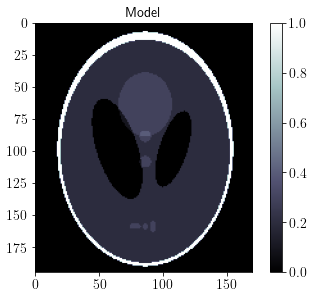

In [23]:
x = occamypy.VectorIC(np.load('./data/shepp_logan_phantom.npy', allow_pickle=True).astype(np.float32)).scale(1 / 255.)

plt.figure(figsize=(5, 4))
plt.imshow(x.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.tight_layout(pad=.5)

plt.title('Model')
#plt.savefig("phantom_model.pdf")
plt.show()

Data:

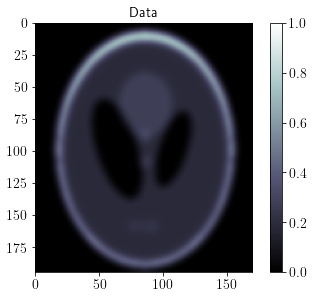

In [24]:
G = occamypy.GaussianFilter(x, [3, 3])
d = G * x

plt.figure(figsize=(5, 4))
plt.imshow(d.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.tight_layout(pad=.5)

plt.title('Data')
#plt.savefig("phantom_data.pdf")
plt.show()

Problem and solver:

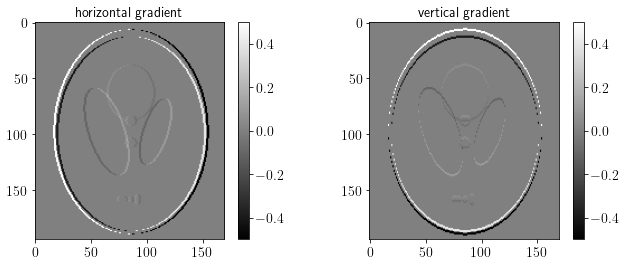

In [25]:
D = occamypy.Gradient(x)
Dx = D*x

plt.figure(figsize=(11, 4))
plt.subplot(121), plt.title('horizontal gradient')
plt.imshow(Dx.vecs[1].getNdArray(), cmap='gray'), plt.colorbar()
plt.subplot(122), plt.title('vertical gradient')
plt.imshow(Dx.vecs[0].getNdArray(), cmap='gray'), plt.colorbar()
plt.show()

Just for comparison, let's solve the problem with CG and FISTA.

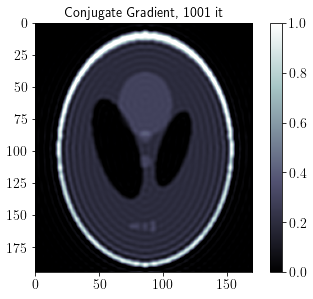

In [26]:
problemCG = occamypy.LeastSquares(x.clone().zero(), d, G)
CG = occamypy.CG(occamypy.BasicStopper(1000))
CG.setDefaults(save_obj=True)
CG.run(problemCG, verbose=False)

plt.figure(figsize=(5, 4))
plt.imshow(problemCG.model.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.tight_layout(pad=.5)

plt.title('Conjugate Gradient, %d it' % len(CG.obj))
# plt.savefig("phantom_cg.pdf")
plt.show()

FISTA α=1.097118e+00


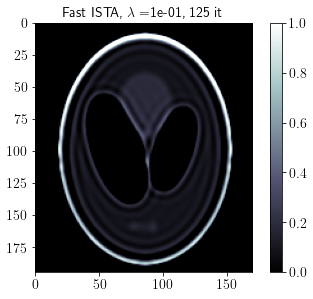

In [27]:
# compute maximum eigenvalue
maxeig = G.powerMethod()
print('FISTA α=%.6e' % (1/(maxeig**2)))
problemFISTA = occamypy.Lasso(x.clone().zero(), d, G, lambda_value=.1, op_norm=maxeig**2)
FISTA = occamypy.ISTA(occamypy.BasicStopper(1000), fast=True)
FISTA.setDefaults(save_obj=True)
FISTA.run(problemFISTA, verbose=False)

plt.figure(figsize=(5, 4))
plt.imshow(problemFISTA.model.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.tight_layout(pad=.5)

plt.title(r'Fast ISTA, $\lambda=$%.e, %d it' % (problemFISTA.lambda_value, len(FISTA.obj)))
#plt.savefig("phantom_fista.pdf")
plt.show()

In [28]:
problemSB = occamypy.RegularizedLeastSquares(x.clone().zero(), d, G, regsL1=D, epsL1=1e-3)
SB = occamypy.SplitBregman(occamypy.BasicStopper(niter=200), niter_inner=3, niter_solver=10,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True)
SB.run(problemSB, verbose=False, inner_verbose=False)

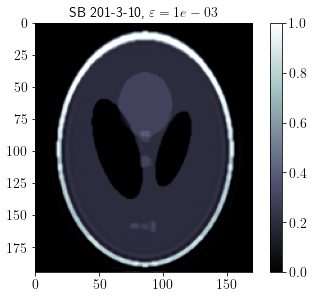

In [29]:
its = "%d-%d-%d" % (len(SB.obj), SB.niter_inner, SB.niter_solver)

plt.figure(figsize=(5, 4))
plt.imshow(problemSB.model.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.tight_layout(pad=.5)

plt.title(r'SB %s, $\varepsilon=%.e$' % (its, problemSB.epsL1[0]))
# plt.savefig("phantom_sb.pdf")
plt.show()

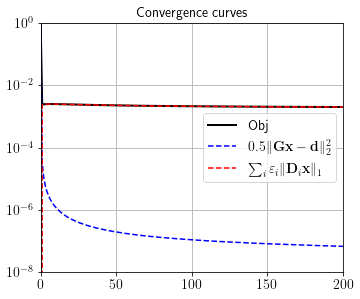

In [30]:
plt.figure(figsize=(5, 4))
plt.semilogy(SB.obj / SB.obj[0], 'k', lw=2, label='Obj')
plt.semilogy(SB.obj_terms[:, 0] / SB.obj[0], 'b--', label=r"$0.5 \Vert \mathbf{Gx-d} \Vert_2^2$")
plt.semilogy(SB.obj_terms[:, 1] / SB.obj[0], 'r--', label=r"$\sum_i\varepsilon_i \Vert \mathbf{D}_i\mathbf{x}\Vert_1$")
plt.legend(loc='right'), plt.grid(True)
plt.xlim(0, 200), plt.ylim(1e-8,1)
plt.tight_layout(pad=.5)

plt.title('Convergence curves')
# plt.savefig("phantom_sb_convergence.pdf")
plt.show()